step  400 | nll=0.4803 | acc_tr=0.347 | acc_te=0.320
step  800 | nll=-1.9360 | acc_tr=0.347 | acc_te=0.313
step 1200 | nll=-4.3098 | acc_tr=0.347 | acc_te=0.347
step 1600 | nll=-5.3584 | acc_tr=0.353 | acc_te=0.300
step 2000 | nll=-5.9688 | acc_tr=0.347 | acc_te=0.300
Shared Σ (learned) ~ near-singular?  log|Σ| = -17.826843


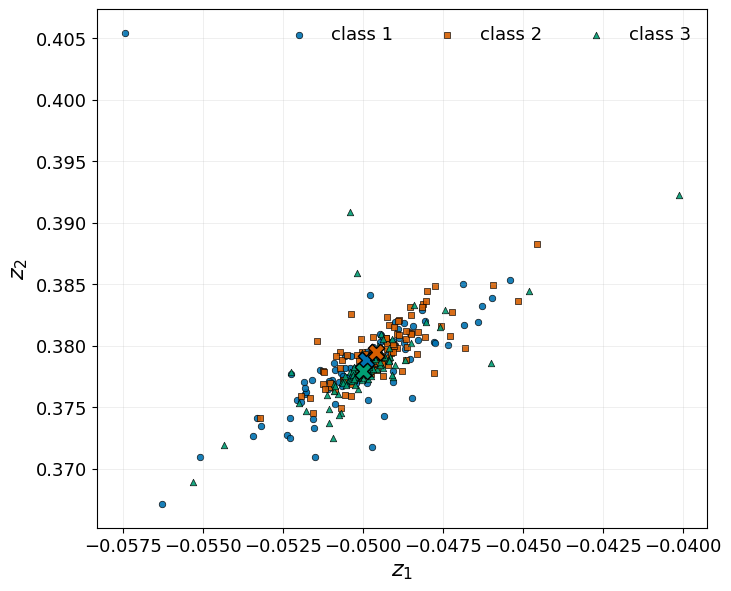

In [7]:
# Figure 3 — Deep LDA: end-to-end likelihood training -> collapse
# Encoder: 2-layer MLP (ReLU, 32 hidden) to 2-D embeddings; joint ML with Adam.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import torch
import torch.nn as nn
import torch.nn.functional as F

rng = np.random.default_rng(1)
#torch.manual_seed(1)

# ----------------------------
# 1) Synthetic data from LDA (Eq. (1)-(2))
# ----------------------------
C, d_in, n = 3, 4, 300          # input dim 4 (nonlinear projection to 2D by encoder)
d_z = 2                          # embedding dim (for visualization)
pi_true  = np.array([1/3, 1/3, 1/3])
mus_true = np.array([[-2.0, -0.5,  0.5,  0.2],
                     [ 2.0,  0.3, -0.2, -0.5],
                     [-0.7, 2.4,  0.1,  0.3]], dtype=float)
Sigma_true = np.array([[1.0, 0.35, 0.0, 0.0],
                       [0.35, 1.1, 0.0, 0.0],
                       [0.0, 0.0, 0.8, 0.2],
                       [0.0, 0.0, 0.2, 0.9]], dtype=float)

ys = rng.choice(C, size=n, p=pi_true)
X  = np.vstack([rng.multivariate_normal(mus_true[c], Sigma_true) for c in ys]).astype(np.float32)

# train/test split (to illustrate poor generalization)
perm = rng.permutation(n)
tr = perm[: n//2]; te = perm[n//2 :]
Xtr, ytr = X[tr], ys[tr]
Xte, yte = X[te], ys[te]

# ----------------------------
# 2) Encoder: 2-layer MLP with ReLU, 32 hidden units -> R^2 (Fig. 3 setup)
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, d_in, d_z, width=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width),
            nn.ReLU(inplace=True),
            nn.Linear(width, d_z),
        )
    def forward(self, x):  # x: [B,d_in]
        return self.net(x)

# ----------------------------
# 3) LDA head params (jointly learned): π, {μ_c}, Σ
#    Unconstrained reparam: π=softmax(α); Σ = L L^T with log-diagonal (Adam)
# ----------------------------
class LDAHead(nn.Module):
    def __init__(self, C, d_z):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(C))           # logits -> π
        self.mu    = nn.Parameter(torch.randn(C, d_z)*0.5)  # class means in z-space
        self.L_free   = nn.Parameter(torch.zeros(d_z, d_z)) # strictly lower
        self.log_diag = nn.Parameter(torch.zeros(d_z))      # diag(L) = exp(log_diag)

    def cholesky(self):
        L = torch.tril(self.L_free).clone()
        idx = torch.arange(L.shape[0])
        L[idx, idx] = torch.exp(self.log_diag)
        return L

    def logpdf_shared(self, z):
        # z: [B,d_z]; returns [B,C] log N(z | μ_c, Σ)
        B, d = z.shape
        C = self.mu.shape[0]
        L = self.cholesky()
        invL = torch.inverse(L)                             # fine for d=2
        logdet = 2.0 * torch.log(torch.diagonal(L)).sum()
        diff = z[:, None, :] - self.mu[None, :, :]          # [B,C,d]
        v = diff @ invL.T                                   # [B,C,d]
        quad = (v**2).sum(dim=2)                            # [B,C]
        return -0.5*(d*np.log(2*np.pi) + logdet + quad)

    def logits(self, z):
        # LDA log-likelihood term for each class + log prior (for NLL on (x,y))
        log_pi = F.log_softmax(self.alpha, dim=0)
        return self.logpdf_shared(z) + log_pi               # [B,C]

# ----------------------------
# 4) Deep LDA model: f_ψ(x) + LDA head; optimize average log-likelihood (Eq. (4))
# ----------------------------
device = "cpu"
enc = Encoder(d_in, d_z, width=32).to(device)
head = LDAHead(C, d_z).to(device)

Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.long, device=device)
Xte_t = torch.tensor(Xte, dtype=torch.float32, device=device)
yte_t = torch.tensor(yte, dtype=torch.long, device=device)

opt = torch.optim.Adam(list(enc.parameters()) + list(head.parameters()), lr=3e-3)  # Adam, end-to-end
# End-to-end ML objective:
def nll_on_batch(x, y):
    z = enc(x)
    lp = head.logits(z)                                    # log p(y|z) up to constant (Eq. (4))
    return -(lp[torch.arange(x.size(0)), y].mean())

# simple training loop
enc.train(); head.train()
for t in range(2000):
    loss = nll_on_batch(Xtr_t, ytr_t)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    if (t+1) % 400 == 0:
        with torch.no_grad():
            ztr = enc(Xtr_t)
            lp_tr = head.logits(ztr).softmax(dim=1)
            acc_tr = (lp_tr.argmax(1) == ytr_t).float().mean().item()
            zte = enc(Xte_t)
            lp_te = head.logits(zte).softmax(dim=1)
            acc_te = (lp_te.argmax(1) == yte_t).float().mean().item()
        print(f"step {t+1:4d} | nll={loss.item():.4f} | acc_tr={acc_tr:.3f} | acc_te={acc_te:.3f}")

# ----------------------------
# 5) Visualize embeddings z = f_ψ(x) after likelihood training (collapse)
# ----------------------------
enc.eval(); head.eval()
with torch.no_grad():
    z_all = enc(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy()
    mu_ml = head.mu.detach().cpu().numpy()
    L_ml  = head.cholesky().detach().cpu().numpy()
    Sigma_ml = L_ml @ L_ml.T
    logdet = np.log(np.linalg.det(Sigma_ml) + 1e-30)

print("Shared Σ (learned) ~ near-singular?  log|Σ| =", logdet)

# Color-blind friendly colors; markers with black edges
OKABE_ITO = ["#0072B2", "#D55E00", "#009E73"]
colors = OKABE_ITO[:C]
markers = ["o", "s", "^"]

def cov_ellipse(mean, cov, k=2.15, **kwargs):  # ~90% mass in 2D
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * k * np.sqrt(np.maximum(vals, 1e-12))
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)

plt.rcParams.update({
    "font.size": 14, "axes.labelsize": 16, "legend.fontsize": 13,
    "xtick.labelsize": 13, "ytick.labelsize": 13
})
fig, ax = plt.subplots(figsize=(7.2, 5.8), constrained_layout=True)

# scatter embeddings by class (labels start from 1)
for c in range(C):
    idx = (ys == c)
    ax.scatter(z_all[idx,0], z_all[idx,1], s=22, c=colors[c], marker=markers[c],
               edgecolors="black", linewidths=0.5, alpha=0.9, label=f"class {c+1}")

# learned class centers and (tiny) covariance ellipses (shared Σ for all)
for c in range(C):
    ax.scatter(mu_ml[c,0], mu_ml[c,1], s=140, marker="X", c=colors[c],
               edgecolors="black", linewidths=1.0, zorder=5)
    #e = cov_ellipse(mu_ml[c], Sigma_ml, k=2.15, edgecolor="black", facecolor="none",
    #                lw=1.2, linestyle="--", alpha=0.9)
    #ax.add_patch(e)

ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend(frameon=False, ncol=3, loc="upper right")
#ax.axis("equal")
pad = 0
xmin, xmax = z_all[:,0].min()-pad, z_all[:,0].max()+pad
ymin, ymax = z_all[:,1].min()-pad, z_all[:,1].max()+pad
#ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
#ax.set_xlim(.14, .16)
#ax.set_ylim(.56, .59)
ax.grid(True, linewidth=0.4, alpha=0.35)
plt.show()
